In [2]:
import cv2
import pylab as plt
from tifffile import imread
import numpy as np
from mptracker import MPTracker

# Load data
data = imread('/Users/joao/data/eyecam/20171009_run000_00000000.tif')
# Load parameters
import json
with open('/Users/joao/lib/mptracker/test.json','r') as f:
    params = json.load(f)
# Init tracker
tracker = MPTracker(params)

{u'contrast_clipLimit': 10, u'crApprox': [[156, 216], [42, 102]], u'eye_radius_mm': 2.4, u'contrast_gridSize': 5, u'invertThreshold': 2, u'points': [[118, 213], [304, 37], [480, 213], [308, 359]], u'number_frames': 512, u'threshold': 75, u'gaussian_filterSize': 5, u'open_kernelSize': 39, u'close_kernelSize': 0}


In [10]:
# Initialize result structure
res = np.zeros(len(data), dtype=[('cr_pix','f4',(2)),
                        ('pupil_pix','f4',(2)),
                        ('pupil_axis','f4',(2)),
                        ('pupil_elipse','f4',(3))])
# Iterate through all frames (This can be done in parallel. Check the dask example if you need speed.)
from tqdm import tqdm # conda install tqdm
for i,frame in tqdm(enumerate(data),
                    desc='Computing pupil locations'):
    _,res[i]['cr_pix'],res[i]['pupil_pix'],res[i]['pupil_axis'],res[i]['pupil_elipse'] = tracker.apply(frame)

Computing pupil locations: 256it [00:06, 39.64it/s]


/users/joao/local/conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


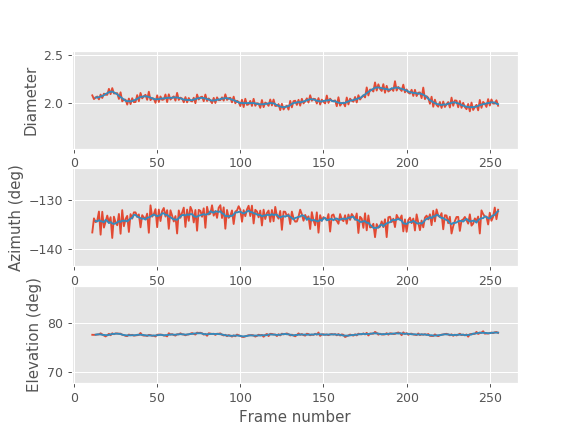

In [8]:
# Get rid of nasty points
cleanupidx = np.where(np.isnan(res['pupil_elipse'][:,0])[:-1] |
                      (np.abs(np.diff(res['pupil_pix'][:,0]))>30))[0]
res['pupil_elipse'][cleanupidx,:] = np.nan
res['pupil_pix'][cleanupidx,:] = np.nan
res['cr_pix'][cleanupidx,:] = np.nan
# Convert pix to units
from mptracker import computePupilDiameterFromEllipse, computeConversionFactor, convertPixelToEyeCoords
reference = np.array([params['points'][0],params['points'][2]])
diam = computePupilDiameterFromEllipse(res['pupil_elipse'][:,:-1],
                                       computeConversionFactor(reference))

diam_smooth = computePupilDiameterFromEllipse(res['pupil_elipse'][:,:-1],
                                              computeConversionFactor(reference),
                                              smoothing='sgolay')

# Check the conversion functions for correctness, they are in utils.py
az,el,theta = convertPixelToEyeCoords(res['pupil_pix'],
                                      reference,
                                      res['cr_pix'])
# Plot results
%matplotlib notebook
plt.matplotlib.style.use('ggplot')
fig = plt.figure()
ax = fig.add_subplot(3,1,1)
plt.plot(diam)
plt.plot(diam_smooth)
plt.ylim(np.array([-.5,.5])+np.nanmedian(diam))

plt.ylabel('Diameter')
fig.add_subplot(3,1,2,sharex = ax)
plt.plot(az)
from scipy.signal import savgol_filter
plt.plot(savgol_filter(az, 
                       window_length = 5,
                       polyorder = 1, 
                       mode='nearest'))
plt.ylim(np.array([-10,10])+np.nanmedian(az))
plt.ylabel('Azimuth (deg)')
fig.add_subplot(3,1,3,sharex = ax)
plt.plot(el)
plt.plot(savgol_filter(el, 
                       window_length = 5,
                       polyorder = 1, 
                       mode='nearest'))
plt.ylim(np.array([-10,10])+np.nanmedian(el))
plt.ylabel('Elevation (deg)')
plt.xlabel('Frame number')
plt.show()

<IPython.core.display.Javascript object>


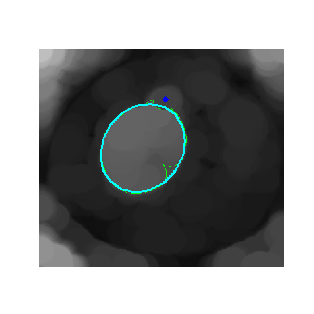

IntSlider(value=210, description=u'Frame', max=255)

In [3]:
from ipywidgets import *
from IPython.display import display
def nbPlayTracking(data,tracker):
    dd = data[210]
    tdat = tracker.apply(dd)
    im = plt.imshow(tdat[0])
    slider = widgets.IntSlider(210,
                               min = 0,
                               max = len(data)-1,
                               step = 1,
                               description='Frame')
    display(slider)
    def updateImage(change):
        dd = data[change['new']]
        tdat = tracker.apply(dd)
        im.set_data(tdat[0])
    slider.observe(updateImage, names='value')
%matplotlib notebook
fig = plt.figure(figsize=[3.5,3.5])
nbPlayTracking(data,tracker)
plt.axis('off');
